<a href="https://colab.research.google.com/github/xs625/ICU-patients/blob/main/Survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Visualisation

In [ ]:
import pandas as pd
import numpy as np
wb = pd.read_csv('ICU.csv')
wb

,Unnamed: 0,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,1,4,0,87,3,1,1,80,96,1
1,2,8,1,27,1,1,1,142,88,1
2,3,12,1,59,2,0,0,112,80,1
3,4,14,1,77,3,0,0,100,70,0
4,5,27,0,76,3,1,1,128,90,1
...,...,...,...,...,...,...,...,...,...,...
195,196,921,0,50,2,1,0,256,64,1
196,197,923,1,20,1,0,0,104,83,1
197,198,924,1,73,3,1,0,162,100,1
198,199,925,1,59,2,0,0,100,88,1


In [ ]:
#Check if NA exists
wb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  200 non-null    int64
 1   ID          200 non-null    int64
 2   Survive     200 non-null    int64
 3   Age         200 non-null    int64
 4   AgeGroup    200 non-null    int64
 5   Sex         200 non-null    int64
 6   Infection   200 non-null    int64
 7   SysBP       200 non-null    int64
 8   Pulse       200 non-null    int64
 9   Emergency   200 non-null    int64
dtypes: int64(10)
memory usage: 15.8 KB


The data consists information from 200 ICU patients. The variables age, gender, systolic blood pressure (SysBP) are numerical data. While the variables Survive, AgeGroup, Sex, Infection and Emergency are categorical data and there is a need to convert the object type from int64 to category in the data preprocessing stage.

There is no missing value.

In [ ]:
#Remove useless column
wb=wb.drop(columns=['Unnamed: 0','ID'])

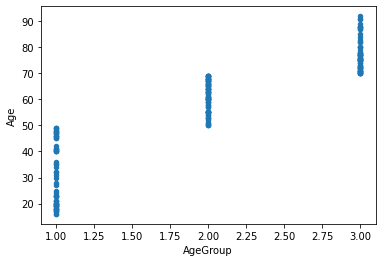

In [ ]:
wb.plot.scatter(x='AgeGroup',y='Age')

The age range for each group are:

*   Group 1: below 50
*   Group 2: 50-70
*   Group 3: above 70


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2319b400>]],
      dtype=object)

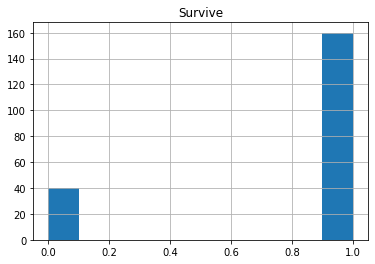

In [ ]:
wb.hist(column = 'Survive')

160 patients survive and 40 are not. There is an obvious class imbalance which may cause the models to be not useful.

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b22ba25e0>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b22abbc10>]]


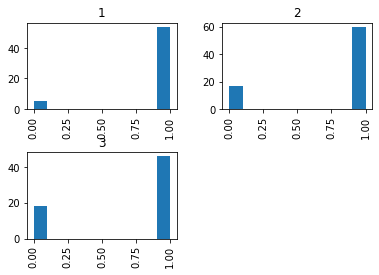

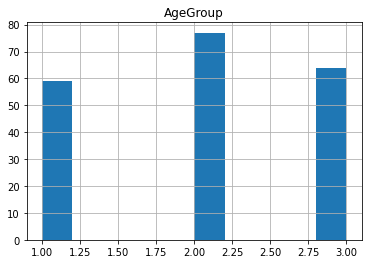

In [ ]:
print(wb.hist(column='Survive',by='AgeGroup'))
print(wb.hist(column = 'AgeGroup'))

We can observe that Group 1 (age below 50) has the lowest mortality rate and highest survival rate which nearly 90% of the patients in group 1 survive. While Group 3 has survival rate near 75% which is the lowest among the groups.

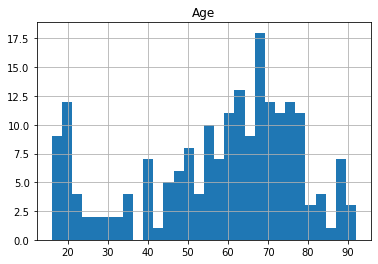

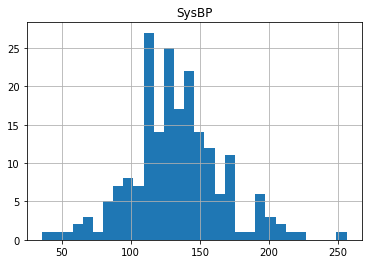

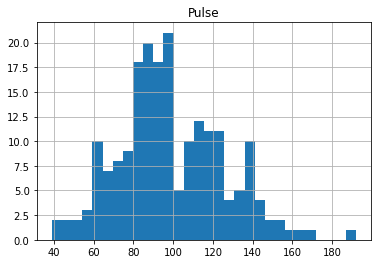

In [ ]:
for col in ['Age','SysBP','Pulse']:
    wb.hist(column=col,bins=30)

The distribution of SysBP and Pulse are skewed to the right and the distributions seem to be normal. However, Age does not show normal distribution.

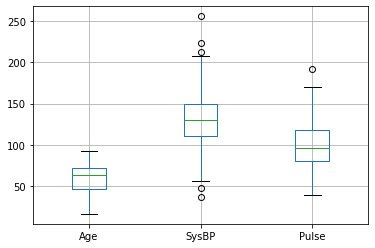

In [ ]:
col = ['Age','SysBP','Pulse']
wb.boxplot(column = col)

Outliers observed in SysBP and Pulse. The range of the three variables vary and hence scaling is needed for logistic regression.

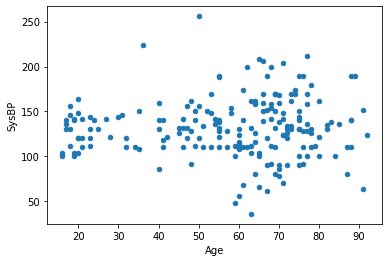

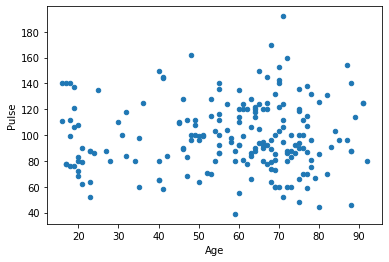

In [ ]:
for col in ['SysBP','Pulse']:
    wb.plot.scatter(x='Age',y=col)

From the scatter graph, two outliers in SysBP seems more obvious while the Pulse does not. Pulse outliers seems acceptable given the data is retrieved from ICU.

In [ ]:
#Find the outliers
wb.loc[wb['SysBP']>220] 

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
142,1,36,1,0,0,224,125,1
195,0,50,2,1,0,256,64,1


In [ ]:
#remove the outliers
wb_clean=wb.drop(wb.index[[142,195]])

#Preprocessing and Scaling 

In [ ]:
#Label encode AgeGroup to class 0,1,2
from sklearn.preprocessing import LabelEncoder,StandardScaler

le = LabelEncoder()
le.fit(wb_clean['AgeGroup'])
le.classes_
label=le.transform(wb_clean['AgeGroup'])
wb_clean['AgeGroup']=label

In [ ]:
#Set the respective column to category object
for col in ['Survive','Sex','AgeGroup','Infection','Emergency']:
    wb_clean[col]=wb_clean[col].astype('category')

#Check if the outliers are removed correctly
print(wb_clean.describe())

#Check if there is duplicate entries
print('Number of duplicate entries:',wb_clean.duplicated().sum())

              Age       SysBP       Pulse
count  198.000000  198.000000  198.000000
mean    57.691919  131.191919   98.969697
std     20.089926   31.229355   26.786031
min     16.000000   36.000000   39.000000
25%     47.000000  110.000000   80.000000
50%     63.000000  130.000000   96.000000
75%     72.000000  150.000000  118.000000
max     92.000000  212.000000  192.000000
Number of duplicate entries: 0


The outliers are removed and the data shows no duplicate entries.

In [ ]:
#Preprocessing for logistic regression which assumes Gaussian distribution
#Standardise Age, SysBP and Pulse
wb_scaled = wb_clean.copy()
col_scale=['Age','SysBP','Pulse']
features = wb_scaled[col_scale]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
wb_scaled[col_scale]=features
print(wb_scaled.describe())

                Age         SysBP         Pulse
count  1.980000e+02  1.980000e+02  1.980000e+02
mean   9.420074e-17 -1.570012e-16  2.242875e-17
std    1.002535e+00  1.002535e+00  1.002535e+00
min   -2.080525e+00 -3.055882e+00 -2.244517e+00
25%   -5.335521e-01 -6.803098e-01 -7.099888e-01
50%    2.648858e-01 -3.826338e-02 -1.111484e-01
75%    7.140071e-01  6.037831e-01  7.122571e-01
max    1.712054e+00  2.594127e+00  3.481894e+00


In [ ]:
from sklearn.model_selection import train_test_split

#get x and y feature variables
#setting the percentage of test set be 0.25 will get percentage of survive around the same for test and train set
X_train,X_test,y_train,y_test=train_test_split(wb_scaled,wb_scaled['Survive'],test_size=0.25,random_state=42,shuffle=True)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

#Ensuring the percentage of survive are constant in both train and test set
print(f'''% Positive class in Train_Clean = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test_Clean  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

(148, 8) (148,)
(50, 8) (50,)
% Positive class in Train_Clean = 19.59
% Positive class in Test_Clean  = 20.0


# Training and Predict


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

logreg = LogisticRegression(solver = 'lbfgs',max_iter = 1000,random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

model_1=logreg.fit(X_train,y_train)
model_2=dt.fit(X_train,y_train)
model_3=rf.fit(X_train,y_train)

y_pred_1=model_1.predict(X_test)
y_pred_2=model_2.predict(X_test)
y_pred_3=model_3.predict(X_test)

for pred in [y_pred_1,y_pred_2,y_pred_3]:
    cnf_matrix= metrics.confusion_matrix(y_test,pred)
    cls_report=classification_report(y_test,pred)
    print(cnf_matrix,cls_report)

[[10  0]
 [ 0 40]]               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        40

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[10  0]
 [ 0 40]]               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        40

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[10  0]
 [ 0 40]]               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        40

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg     

The models show 100% accuracy. This further proves that class imbalance will cause the models to 'memorise' the trend to predict the majority class. This will create a biased result.Hence, it is necessary to ensure the training process are independent to avoid memorisation.

Another reason for 100% accuracy to happen is due model complexity in decision tree classification and random forest classification.

# Cross Validation
This is a common technique which allows the models to train independently.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean,std
X = wb_scaled.iloc[:,1:7].values
y = wb_scaled.iloc[:,0].values

mean_scores_logreg=list()
mean_scores_dt=list()
mean_scores_rf=list()

std_scores_logreg=list()
std_scores_dt=list()
std_scores_rf=list()
for i in range (10,51):
  cv = KFold(n_splits=i,random_state=42,shuffle=True)

  scores_1 = cross_val_score(logreg,X,y,scoring='accuracy',cv=cv)
  scores_2 = cross_val_score(dt,X,y,scoring='accuracy',cv=cv)
  scores_3 = cross_val_score(rf,X,y,scoring='accuracy',cv=cv)

  mean_scores_logreg.append(mean(scores_1))
  mean_scores_dt.append(mean(scores_2))
  mean_scores_rf.append(mean(scores_3))

  std_scores_logreg.append(std(scores_1))
  std_scores_dt.append(std(scores_2))
  std_scores_rf.append(std(scores_3))

In [ ]:
Accuracy=pd.DataFrame({'mean_logreg':mean_scores_logreg,'std_logreg':std_scores_logreg,
                              'mean_dt':mean_scores_dt,'std_dt':std_scores_dt,
                              'mean_rf':mean_scores_rf,'std_rf':std_scores_rf})
Accuracy.describe()

,mean_logreg,std_logreg,mean_dt,std_dt,mean_rf,std_rf
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.796948,0.157514,0.697018,0.148271,0.788885,0.132857
std,0.005777,0.043582,0.014185,0.043395,0.007584,0.032982
min,0.788333,0.072179,0.657754,0.056689,0.772109,0.065086
25%,0.792929,0.120961,0.691534,0.112056,0.783816,0.107134
50%,0.794163,0.157272,0.696860,0.154349,0.787946,0.139742
75%,0.801667,0.200164,0.701852,0.188001,0.793395,0.166733
max,0.808134,0.216629,0.732323,0.216689,0.803571,0.177575


Logistic regression has the highest accuracy than other models on average while random forest classification has the lowest standard deviation than other models on average. 

In [ ]:
maxValueIndex = Accuracy.idxmax()
 
print("Maximum values of columns are at row index position :")
print(maxValueIndex)

Maximum values of columns are at row index position :
mean_logreg     9
std_logreg     33
mean_dt         1
std_dt         31
mean_rf        32
std_rf         34
dtype: int64


Optimal number of splits for each model:

*   Logistic Regression: 20
*   Decision Tree: 10
*   Random Forest: 42

# Repeated Cross Validation

This technique helps to reduce the noise in the dataset. The optimal number of splits will be used in the following training.

In [ ]:
from sklearn.model_selection import RepeatedKFold
from numpy import mean,std
from scipy.stats import sem
def evaluate_cv_rep(splits,X,y,model,repeats):
  cv_rep = RepeatedKFold(n_splits=splits,random_state=42,n_repeats=repeats)
  scores_rep = cross_val_score(model,X,y,scoring='accuracy',cv=cv_rep)
  return scores_rep

mean_rep_logreg=list()
mean_rep_dt=list()
mean_rep_rf=list()

std_rep_logreg=list()
std_rep_dt=list()
std_rep_rf=list()

for repeat in range(1,16):
  scores_1=evaluate_cv_rep(20,X,y,logreg,repeat)
  scores_2=evaluate_cv_rep(10,X,y,dt,repeat)
  scores_3=evaluate_cv_rep(42,X,y,dt,repeat)

  mean_rep_logreg.append(mean(scores_1))
  mean_rep_dt.append(mean(scores_2))
  mean_rep_rf.append(mean(scores_3))

  std_rep_logreg.append(sem(scores_1))
  std_rep_dt.append(sem(scores_2))
  std_rep_rf.append(sem(scores_3))

In [ ]:
Accuracy_rep=pd.DataFrame({'mean_logreg':mean_rep_logreg,'std_logreg':std_rep_logreg,
                       'mean_dt':mean_rep_dt,'std_dt':std_rep_dt,
                       'mean_rf':mean_rep_rf,'std_rf':std_rep_rf})

In [ ]:
Accuracy_rep.describe()

,mean_logreg,std_logreg,mean_dt,std_dt,mean_rf,std_rf
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.800837,0.011456,0.703959,0.010570,0.700050,0.013941
std,0.000889,0.006610,0.006630,0.003180,0.006842,0.006579
min,0.799500,0.006917,0.696316,0.007554,0.692560,0.008264
25%,0.800198,0.007524,0.700233,0.008383,0.695304,0.009373
50%,0.800556,0.008855,0.701767,0.009403,0.697835,0.011519
75%,0.801435,0.012227,0.705632,0.011602,0.702843,0.015816
max,0.802778,0.032044,0.720614,0.018896,0.717857,0.031734


With repeated KFolds, logistic regression has the highest accuracy among the models and the accuracy improves from the non-repeated KFolds. Decision Tree model shows the lowest standard deviation among the models.

In [ ]:
maxValueIndex = Accuracy_rep.idxmax()
 
print("Maximum values of columns are at row index position :")
print(maxValueIndex)

Maximum values of columns are at row index position :
mean_logreg    3
std_logreg     0
mean_dt        2
std_dt         0
mean_rf        0
std_rf         0
dtype: int64


Hence, the optimal tuning for each models is:

*   Logistic Regression: 4 repeats with 20 splits 
*   Decision Tree: 3 repeats with 10 splits
*   Random Forest: 1 repeat with 42 splits

The best classification model is logistic regression with 80.28% of accuracy.